# Week 7 HW - Vector Space Word Embeddings

In [6]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import spacy
import copy

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths
import pickle

nlp = spacy.load('en')

In [7]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

### Reading , Pre-processing (and Saving) Data

In [50]:
reddit_submissions_min= pandas.read_csv('../project_data/reddit_submissions_2015_18.csv', index_col=6)[['author', 'created_utc', 'subreddit', 
                                                                                                        'title', 'selftext', 'distinguished',
                                                                                                       'num_comments','score']]
reddit_submissions_min['created_datetime'] = pandas.to_datetime(reddit_submissions_min['created_utc'], unit='s')

/home/mathew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
reddit_submissions_min['created_tranche'] = pandas.cut(reddit_submissions_min['created_utc'], bins = 20, labels = list(range(20)))

reddit_submissions_min['subreddit'].value_counts()

reddit_submissions_incels = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'Incels')]
reddit_submissions_incels['post_text'] = reddit_submissions_incels['title'] + " " + reddit_submissions_incels['selftext']
reddit_submissions_incels['tokenized_sents'] = reddit_submissions_incels['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_incels['normalized_sents'] = reddit_submissions_incels['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

reddit_submissions_altright = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'altright')]
reddit_submissions_altright['post_text'] = reddit_submissions_altright['title'] + " " + reddit_submissions_altright['selftext']
reddit_submissions_altright['tokenized_sents'] = reddit_submissions_altright['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_altright['normalized_sents'] = reddit_submissions_altright['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

reddit_submissions_min8 = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'The_Donald') & 
                                                       (reddit_submissions_min['created_tranche'] == 8)]
reddit_submissions_min4 = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'The_Donald') & 
                                                       (reddit_submissions_min['created_tranche'] == 4)]

reddit_submissions_min8['post_text'] = reddit_submissions_min8['title'] + " " + reddit_submissions_min8['selftext']
reddit_submissions_min8['tokenized_sents'] = reddit_submissions_min8['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_min8['normalized_sents'] = reddit_submissions_min8['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

reddit_submissions_min4['post_text'] = reddit_submissions_min4['title'] + " " + reddit_submissions_min4['selftext']
reddit_submissions_min4['tokenized_sents'] = reddit_submissions_min4['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_min4['normalized_sents'] = reddit_submissions_min4['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

with open('reddit_submissions_incels_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_incels, f)
    
with open('reddit_submissions_altright_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_altright, f)
    
with open('reddit_submissions_donald8_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_min8, f)   
    
with open('reddit_submissions_donald4_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_min4, f)  
    
with open('reddit_submissions_donald_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_trump, f)  
    
donald8_W2V.save("donald8_WORD2Vec")
donald4_W2V.save("donald4_WORD2Vec")
donald8_W2Vsoft.save("donald8_WORD2Vec_soft")
donald4_W2Vsoft.save("donald4_WORD2Vec_soft")

In [20]:
with open('reddit_submissions_donald8_tkns.pkl', 'rb') as f:
    reddit_submissions_min8 = pickle.load(f)
    
with open('reddit_submissions_donald4_tkns.pkl', 'rb') as f:
    reddit_submissions_min4 = pickle.load(f)

with open('reddit_submissions_altright_tkns.pkl', 'rb') as f:
    reddit_submissions_altright = pickle.load(f)
    
with open('reddit_submissions_incels_tkns.pkl', 'rb') as f:
    reddit_submissions_incels = pickle.load(f)

with open('reddit_submissions_donald_tkns.pkl', 'rb') as f:
    reddit_submissions_trump = pickle.load(f)
    

with open('donald8_WORD2Vec', 'rb') as f:
    donald8_W2V = pickle.load(f)
    
with open('donald4_WORD2Vec', 'rb') as f:
    donald4_W2V = pickle.load(f)
    
with open('donald8_WORD2Vec_soft', 'rb') as f:
    donald8_W2Vsoft = pickle.load(f)
    
with open('donald4_WORD2Vec_soft', 'rb') as f:
    donald4_W2Vsoft = pickle.load(f)

## Exercise 1 -- word2vec 

Tasks:
- Try 2 `word2vec` specifications
- Visualize each of them with two viz techniques
- Arithmetic on words

I'm creating two versions of both the CBOW and Skipgram version, one for Super Tuesday(T4), and one in the month before the general election (T8).

### CBOW version

In [53]:
donald8_W2V = gensim.models.word2vec.Word2Vec(reddit_submissions_min8['normalized_sents'].sum())
donald4_W2V = gensim.models.word2vec.Word2Vec(reddit_submissions_min4['normalized_sents'].sum())

#### Word Similarity

In [54]:
donald8_W2V.most_similar('liberal')

[('leave', 0.9967672824859619),
 ('scare', 0.996751070022583),
 ('black', 0.9965715408325195),
 ('tire', 0.9961039423942566),
 ('life', 0.9950675368309021),
 ('americans', 0.9948298931121826),
 ('stand', 0.9947570562362671),
 ('racist', 0.9942721724510193),
 ('understand', 0.9941738843917847),
 ('fight', 0.9935716390609741)]

In [55]:
donald4_W2V.most_similar('liberal')

[('male', 0.9716025590896606),
 ('shit', 0.9648157954216003),
 ('family', 0.9588555693626404),
 ('cis', 0.9580625295639038),
 ('art', 0.956328809261322),
 ('black', 0.9544196128845215),
 ('white', 0.951651930809021),
 ('life', 0.9513400793075562),
 ('girl', 0.9489227533340454),
 ('grow', 0.9488340616226196)]

- `liberal` has words with closer association in T8 over T4 => more central in the discourse then?
- In T4, it seems interchangeable with other markers of identity, while in T8, the language seems closer to that of fear.

In [33]:
donald4_W2V.most_similar('immigration')

[('immigrant', 0.9980612397193909),
 ('illegal', 0.984207034111023),
 ('border', 0.9784513711929321),
 ('american', 0.9715807437896729),
 ('alien', 0.9578444361686707),
 ('mexico', 0.9573886394500732),
 ('government', 0.9465535879135132),
 ('law', 0.9439253807067871),
 ('trade', 0.9404299259185791),
 ('wall', 0.9388926029205322)]

In [34]:
donald8_W2V.most_similar('immigration')

[('bear', 0.9997624158859253),
 ('division', 0.9996041059494019),
 ('protection', 0.9995772838592529),
 ('pull', 0.9995088577270508),
 ('intend', 0.9994912147521973),
 ('terrorism', 0.9994733333587646),
 ('son', 0.9994708299636841),
 ('healthcare', 0.9994666576385498),
 ('mistake', 0.999466061592102),
 ('ship', 0.9994590282440186)]

- In T4, `immigration` shows up with `mexico`, `alien`, and `law` - legal and economic terms, and with a sharper fall-off than T8.
- T8 words include more fear-like language: `division`, `protection`, `terrorism`. 

In [43]:
donald4_W2V.most_similar('foreign')

[('law', 0.993635892868042),
 ('u.s', 0.9925585985183716),
 ('undocumented', 0.9922058582305908),
 ('mexican', 0.9921127557754517),
 ('workforce', 0.9907346963882446),
 ('trade', 0.9903888702392578),
 ('health', 0.9903799295425415),
 ('refugee', 0.990288496017456),
 ('alien', 0.9899847507476807),
 ('rape', 0.9895515441894531)]

In [44]:
donald8_W2V.most_similar('foreign')

[('influence', 0.9978323578834534),
 ('congress', 0.9976338148117065),
 ('million', 0.9975787997245789),
 ('allow', 0.9973333477973938),
 ('supreme', 0.9970723390579224),
 ('illegal', 0.9969939589500427),
 ('refuse', 0.9968581795692444),
 ('close', 0.9967610836029053),
 ('exception', 0.9966164231300354),
 ('court', 0.9965746402740479)]

In [60]:
donald8_W2V.most_similar('democrat')

[('person', 0.9972376823425293),
 ('change', 0.9961291551589966),
 ('rig', 0.9946810007095337),
 ('republican', 0.9942684173583984),
 ('college', 0.9942322969436646),
 ('candidate', 0.9935974478721619),
 ('primary', 0.9930822849273682),
 ('chance', 0.9918277263641357),
 ('sander', 0.9912192821502686),
 ('lose', 0.9908117055892944)]

In [61]:
donald4_W2V.most_similar('democrat')

[('register', 0.9837706685066223),
 ('democratic', 0.9816001057624817),
 ('presidential', 0.9801721572875977),
 ('steal', 0.9671924710273743),
 ('general', 0.9667967557907104),
 ('establishment', 0.9663398861885071),
 ('lose', 0.9661449193954468),
 ('election', 0.963850736618042),
 ('republicans', 0.9634897708892822),
 ('independent', 0.9596998691558838)]

Fears of `democrats` `stealing` or `rigging` the election seem to be stable over the two periods.

In [73]:
donald4_W2V.most_similar('mexican')

[('u.s', 0.9978862404823303),
 ('refugee', 0.9968644380569458),
 ('citizen', 0.9962786436080933),
 ('china', 0.995557427406311),
 ('islamic', 0.9953213334083557),
 ('system', 0.994718074798584),
 ('trade', 0.9943752884864807),
 ('workforce', 0.9938507080078125),
 ('exploit', 0.9937943816184998),
 ('undocumented', 0.9934136867523193)]

In [72]:
donald8_W2V.most_similar('mexican')

[('ideology', 0.9991565346717834),
 ('young', 0.9990911483764648),
 ('tear', 0.9990442395210266),
 ('sjw', 0.9988831281661987),
 ('ass', 0.9988289475440979),
 ('disgrace', 0.9988203048706055),
 ('jewish', 0.998818039894104),
 ('wall', 0.9988049864768982),
 ('smart', 0.9987630844116211),
 ('table', 0.9987449645996094)]

#### Arithmetic Ops

In [74]:
donald8_W2V.most_similar(positive=['mexican', 'clinton'],
                        negative = ['trump'])

[('john', 0.9441418051719666),
 ('/watch?v=_x16_kzx1ve', 0.92958664894104),
 ('release', 0.9286057949066162),
 ('fbi', 0.9279534816741943),
 ('leak', 0.9207971096038818),
 ('include', 0.9196463227272034),
 ('would', 0.9175896048545837),
 ('$', 0.915286660194397),
 ('server', 0.9102073907852173),
 ('dnc', 0.903327226638794)]

In [31]:
donald4_W2V.most_similar(positive=['mexican', 'clinton'],
                        negative = ['trump'])

[('money', 0.9284423589706421),
 ('rape', 0.9068623781204224),
 ('law', 0.9020838737487793),
 ('government', 0.8991795778274536),
 ('live', 0.897837221622467),
 ('political', 0.8973218202590942),
 ('federal', 0.8971464037895203),
 ('year', 0.8954259157180786),
 ('system', 0.8929711580276489),
 ('spend', 0.8913201093673706)]

`rape` showing up here is a pointer to Trump's claims of mexican rapists crossing the border.

In [32]:
donald8_W2V.most_similar(positive=['clinton'], negative = ['trump'])

[('email', 0.6836228966712952),
 ('podesta', 0.6682961583137512),
 ('wikileaks', 0.4856630563735962),
 ('john', 0.4494193494319916),
 ('link', 0.447030246257782),
 ('/watch?v=_x16_kzx1ve', 0.38258862495422363),
 ('would', 0.3818235397338867),
 ('release', 0.3699149787425995),
 ('new', 0.34082427620887756),
 ('$', 0.34018778800964355)]

Clinton's emails stood out the most in relative to Trump in T8.

In [33]:
donald4_W2V.most_similar(positive=['clinton'], negative = ['trump'])

[('party', 0.25138312578201294),
 ('old', 0.24983689188957214),
 ('establishment', 0.23953571915626526),
 ('democrat', 0.2300279438495636),
 ('ago', 0.21886283159255981),
 ('election', 0.21076297760009766),
 ('hillary', 0.20213009417057037),
 ('republican', 0.19957371056079865),
 ('ted', 0.19468846917152405),
 ('general', 0.19377833604812622)]

The presence of `establishment`, `old`, and `party` in T4 point to how Clinton was the old hand of the Democratic party, the embodiment of establishment politics -- everything Trump railed against.

In [36]:
donald8_W2V.most_similar(positive=['immigrant', 'clinton'],
                        negative = ['trump'])

[('john', 0.9469062685966492),
 ('release', 0.9306682348251343),
 ('fbi', 0.9296881556510925),
 ('/watch?v=_x16_kzx1ve', 0.9291980862617493),
 ('would', 0.9220211505889893),
 ('$', 0.9189087152481079),
 ('include', 0.9179779291152954),
 ('leak', 0.9166549444198608),
 ('server', 0.9069513082504272),
 ('dnc', 0.9046506881713867)]

In [39]:
donald4_W2V.most_similar(positive=['immigrant', 'clinton'],
                        negative = ['trump'])

[('illegal', 0.8895357847213745),
 ('immigration', 0.8847132921218872),
 ('border', 0.865604043006897),
 ('government', 0.8583777546882629),
 ('american', 0.8583025932312012),
 ('law', 0.8526616096496582),
 ('mexico', 0.8514382839202881),
 ('alien', 0.850590705871582),
 ('trade', 0.8327457904815674),
 ('money', 0.8253312110900879)]

In [124]:
donald8_W2V.most_similar('woman')

[('racist', 0.995869517326355),
 ('stand', 0.995624303817749),
 ('choice', 0.9955204129219055),
 ('corrupt', 0.9954726099967957),
 ('pro', 0.9951475858688354),
 ('policy', 0.9949957728385925),
 ('accept', 0.9948590993881226),
 ('courage', 0.9947192072868347),
 ('daddy', 0.9945763945579529),
 ('family', 0.994556725025177)]

In [123]:
donald4_W2V.most_similar('woman')

[('care', 0.9855266809463501),
 ('money', 0.9820683598518372),
 ('war', 0.9786428809165955),
 ('problem', 0.9776806831359863),
 ('europe', 0.9766192436218262),
 ('million', 0.9762384295463562),
 ('politician', 0.9738833904266357),
 ('black', 0.9736466407775879),
 ('political', 0.9725786447525024),
 ('isis', 0.9717080593109131)]

#### Word Distributions

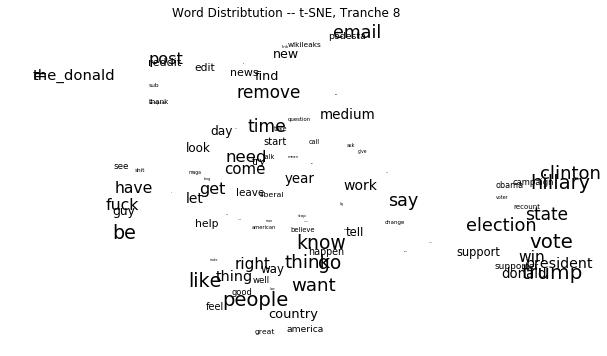

In [47]:
numWords = 100
targetWords_d8 = donald8_W2V.wv.index2word[:numWords]

wordsSubMatrix_d8 = []
for word in targetWords_d8:
    wordsSubMatrix_d8.append(donald8_W2V[word])
wordsSubMatrix_d8 = np.array(wordsSubMatrix_d8)

pcaWords_d8 = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix_d8)
reducedPCA_data_d8 = pcaWords_d8.transform(wordsSubMatrix_d8)
#T-SNE is theoretically better, but you should experiment
tsneWords_d8 = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data_d8)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_d8[:, 0], tsneWords_d8[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords_d8):
    ax.annotate(word, (tsneWords_d8[:, 0][i],tsneWords_d8[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
ax.set_title("Word Distribtution -- t-SNE, Tranche 8")
plt.show()

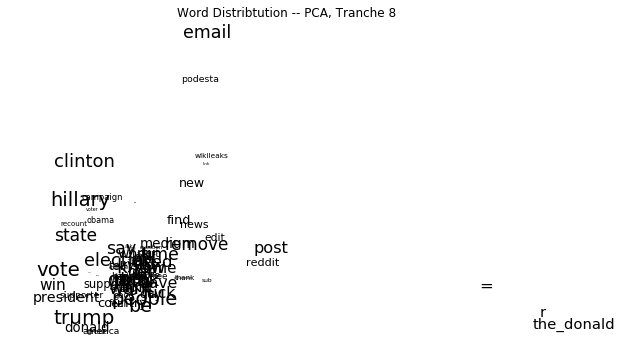

In [48]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data_d8[:, 0], reducedPCA_data_d8[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords_d8):
    ax.annotate(word, (reducedPCA_data_d8[:, 0][i],reducedPCA_data_d8[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
ax.set_title("Word Distribtution -- PCA, Tranche 8")
plt.show()

PCA is so much messier.

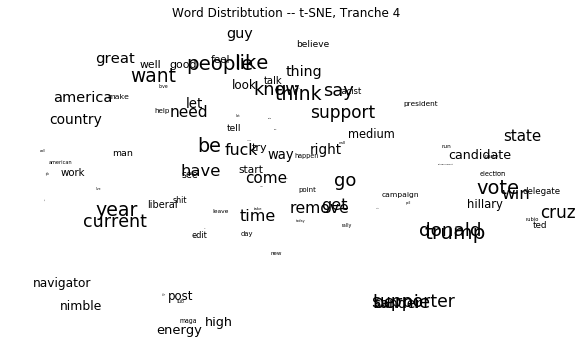

In [49]:
numWords = 100
targetWords_d4 = donald4_W2V.wv.index2word[:numWords]

wordsSubMatrix_d4 = []
for word in targetWords_d4:
    wordsSubMatrix_d4.append(donald4_W2V[word])
wordsSubMatrix_d4 = np.array(wordsSubMatrix_d4)

pcaWords_d4 = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix_d4)
reducedPCA_data_d4 = pcaWords_d4.transform(wordsSubMatrix_d4)
#T-SNE is theoretically better, but you should experiment
tsneWords_d4 = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data_d4)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_d4[:, 0], tsneWords_d4[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords_d4):
    ax.annotate(word, (tsneWords_d4[:, 0][i],tsneWords_d4[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
ax.set_title("Word Distribtution -- t-SNE, Tranche 4")
plt.show()

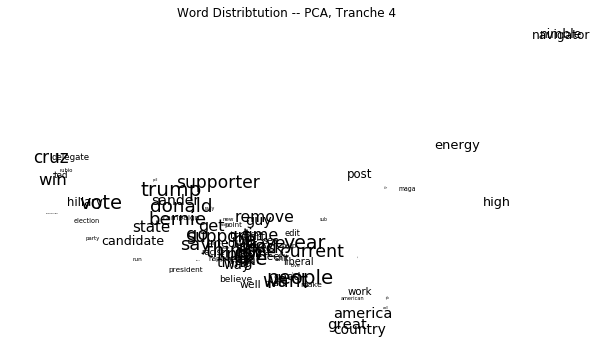

In [50]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data_d4[:, 0], reducedPCA_data_d4[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords_d4):
    ax.annotate(word, (reducedPCA_data_d4[:, 0][i],reducedPCA_data_d4[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
ax.set_title("Word Distribtution -- PCA, Tranche 4")
plt.show()

### Skip-gram version

In [4]:
donald8_W2V_sg = gensim.models.word2vec.Word2Vec(reddit_submissions_min8['normalized_sents'].sum(), sg = 1)
donald4_W2V_sg = gensim.models.word2vec.Word2Vec(reddit_submissions_min4['normalized_sents'].sum(), sg = 1)

In [10]:
donald8_W2V_sg.most_similar('liberal')

[('conservative', 0.9326992034912109),
 ('idiot', 0.9031180143356323),
 ('leave', 0.8827015161514282),
 ('wing', 0.8798536062240601),
 ('establishment', 0.8753505349159241),
 ('brainwash', 0.872607946395874),
 ('politic', 0.8658599853515625),
 ('scare', 0.865500271320343),
 ('sjw', 0.8630936145782471),
 ('tire', 0.8629779815673828)]

In [9]:
donald4_W2V_sg.most_similar('liberal')

[('leftist', 0.8481932878494263),
 ('sjw', 0.841654896736145),
 ('age', 0.8387141227722168),
 ('progressive', 0.8294395804405212),
 ('feed', 0.8234485387802124),
 ('regressive', 0.8226796984672546),
 ('young', 0.821613073348999),
 ('tolerant', 0.8184260129928589),
 ('moderate', 0.8172438144683838),
 ('uneducated', 0.8109108805656433)]

The results for the skipgram model are so much more sensible.

In [13]:
donald8_W2V_sg.most_similar('immigrant')

[('poor', 0.9863131046295166),
 ('extreme', 0.9849162697792053),
 ('refugee', 0.9835894107818604),
 ('advocate', 0.9827237129211426),
 ('african', 0.9826608300209045),
 ('belief', 0.9817240238189697),
 ('powerful', 0.9814281463623047),
 ('benefit', 0.981043815612793),
 ('european', 0.9809878468513489),
 ('radical', 0.9807344675064087)]

In [14]:
donald4_W2V_sg.most_similar('immigrant')

[('deport', 0.9285572171211243),
 ('illegal', 0.923522412776947),
 ('alien', 0.9074271321296692),
 ('immigration', 0.9034764766693115),
 ('legal', 0.9031280279159546),
 ('undocumented', 0.8746004700660706),
 ('mexican', 0.8649813532829285),
 ('cross', 0.8592754602432251),
 ('illegally', 0.8500134944915771),
 ('law', 0.848778486251831)]

T4: Legal status of the `immigrant`  
T8: Personal characteristics of the `immigrant`

In [18]:
donald8_W2V_sg.most_similar('mexican')

[('canada', 0.9922851324081421),
 ('christian', 0.99192214012146),
 ('ethnic', 0.9908666610717773),
 ('flee', 0.9905797243118286),
 ('christians', 0.9902743101119995),
 ('attitude', 0.9901493787765503),
 ('betray', 0.9899754524230957),
 ('patriotic', 0.9893020391464233),
 ('eu', 0.9883866906166077),
 ('vast', 0.988200306892395)]

In [19]:
donald4_W2V_sg.most_similar('mexican')

[('undocumented', 0.9677998423576355),
 ('alien', 0.9640153646469116),
 ('u.s', 0.9638773202896118),
 ('china', 0.9533690214157104),
 ('agreement', 0.9510550498962402),
 ('citizen', 0.9502668380737305),
 ('enforce', 0.9490730166435242),
 ('manufacture', 0.94845050573349),
 ('native', 0.947941780090332),
 ('citizenship', 0.9470487833023071)]

T4: `Mexican` as a legal status  
T8: `Mexican` as an ethnicity

#### Arithmetic

In [75]:
trump_nazi_wv_mul = donald8_W2V_sg.wv.get_vector('trump')*donald8_W2V_sg.wv.get_vector('nazi')
donald8_W2V_sg.wv.most_similar(positive=[trump_nazi_wv_mul,])

[('@northpoint', 0.29853272438049316),
 ('@tpccharlotte', 0.2157765030860901),
 ('dark_magi', 0.13642416894435883),
 ('raylanwest', 0.07764790952205658),
 ('@pbcraleigh', 0.05850385129451752),
 ('@summitrdu', 0.05015171319246292),
 ('@covenantchurch2', 0.04325195774435997),
 ('@churchonmorgan', 0.04299210011959076),
 ('r', 0.03721966966986656),
 ('@mychampcity', 0.029840819537639618)]

Strangely, these are all twitter handles and two reddit users. And the Twitter handles are all church groups?

Multiplication of word-vectors seems to be the interaction of the two vectors. So Trump * Nazi = Church twitter? I'm completely stumped, yet not fully surprised.

In [77]:
trump_nazi_wv_div = donald8_W2V_sg.wv.get_vector('trump')/donald8_W2V_sg.wv.get_vector('nazi')
donald8_W2V_sg.wv.most_similar(positive=[trump_nazi_wv_div,])

[('day', 0.16442044079303741),
 ('@tpccharlotte', 0.1598035991191864),
 ('trump', 0.12456533312797546),
 ('news', 0.12332571297883987),
 ('post', 0.12143290042877197),
 ('iugwlfy5&amp;sh', 0.12049691379070282),
 ('http://dioceseoflasvegas.org/contacts.aspx', 0.1192387267947197),
 ('subreddit', 0.10470153391361237),
 ('http://www.mostdamagingwikileaks.com/', 0.10220786929130554),
 ('trumpsrb', 0.09936121851205826)]

#### Word Distribution

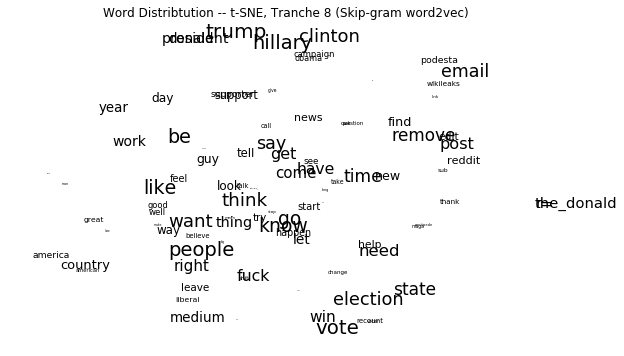

In [51]:
numWords = 100
targetWords_d8_sg = donald8_W2V_sg.wv.index2word[:numWords]

wordsSubMatrix_d8_sg = []
for word in targetWords_d8_sg:
    wordsSubMatrix_d8_sg.append(donald8_W2V_sg[word])
wordsSubMatrix_d8_sg = np.array(wordsSubMatrix_d8_sg)

pcaWords_d8_sg = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix_d8_sg)
reducedPCA_data_d8_sg = pcaWords_d8_sg.transform(wordsSubMatrix_d8_sg)
#T-SNE is theoretically better, but you should experiment
tsneWords_d8_sg = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data_d8_sg)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_d8_sg[:, 0], tsneWords_d8_sg[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords_d8_sg):
    ax.annotate(word, (tsneWords_d8_sg[:, 0][i],tsneWords_d8_sg[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
ax.set_title("Word Distribtution -- t-SNE, Tranche 8 (Skip-gram word2vec)")
plt.show()

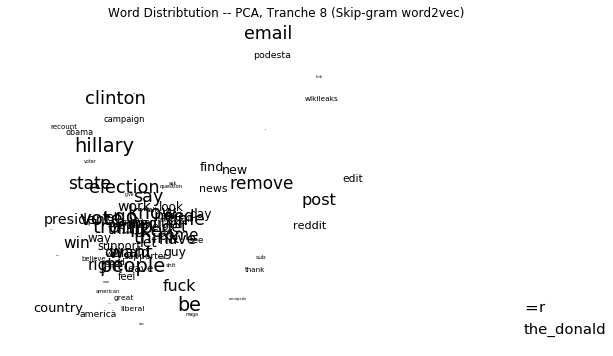

In [53]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data_d8_sg[:, 0], reducedPCA_data_d8_sg[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords_d8_sg):
    ax.annotate(word, (reducedPCA_data_d8_sg[:, 0][i],reducedPCA_data_d8_sg[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
ax.set_title("Word Distribtution -- PCA, Tranche 8 (Skip-gram word2vec)")
plt.show()

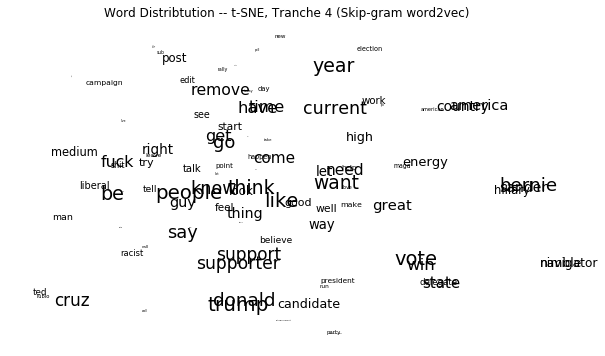

In [52]:
numWords = 100
targetWords_d4_sg = donald4_W2V_sg.wv.index2word[:numWords]

wordsSubMatrix_d4_sg = []
for word in targetWords_d4_sg:
    wordsSubMatrix_d4_sg.append(donald4_W2V_sg[word])
wordsSubMatrix_d4_sg = np.array(wordsSubMatrix_d4_sg)

pcaWords_d4_sg = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix_d4_sg)
reducedPCA_data_d4_sg = pcaWords_d4_sg.transform(wordsSubMatrix_d4_sg)
#T-SNE is theoretically better, but you should experiment
tsneWords_d4_sg = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data_d4_sg)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords_d4_sg[:, 0], tsneWords_d4_sg[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords_d4_sg):
    ax.annotate(word, (tsneWords_d4_sg[:, 0][i],tsneWords_d4_sg[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
ax.set_title("Word Distribtution -- t-SNE, Tranche 4 (Skip-gram word2vec)")
plt.show()

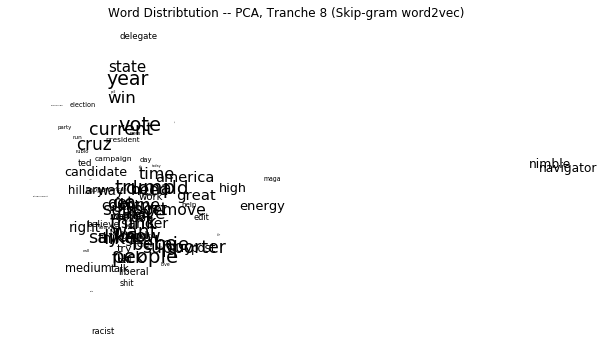

In [55]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data_d4_sg[:, 0], reducedPCA_data_d4_sg[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords_d4_sg):
    ax.annotate(word, (reducedPCA_data_d4_sg[:, 0][i],reducedPCA_data_d4_sg[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
ax.set_title("Word Distribtution -- PCA, Tranche 8 (Skip-gram word2vec)")
plt.show()

## Exercise 2 -- doc2vec

In [51]:
reddit_submissions_trump = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'The_Donald')]
reddit_submissions_trump['post_text'] = reddit_submissions_trump['title'] + " " + reddit_submissions_trump['selftext']
reddit_submissions_trump['tokenized_words'] = reddit_submissions_trump['post_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))

/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
reddit_submissions_trump['normalized_words'] = reddit_submissions_trump['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

with open('reddit_submissions_donald_tkns_d2v', 'wb') as f:
    pickle.dump(reddit_submissions_trump, f)

/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
keywords = ['election', 'immigration', 'democrat', 'racial', 'news', 'russia', 'nazi', 'email', 'conspiracy', 'fbi']

taggedDocs = []
for index, row in reddit_submissions_trump.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
#     docKeywords.append(row['author'])
#     docKeywords.append(row['created_datetime'])
    docKeywords.append(index) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
reddit_submissions_trump['TaggedPostText'] = taggedDocs

trump_D2V = gensim.models.doc2vec.Doc2Vec(reddit_submissions_trump['TaggedPostText'], size = 150) #Limiting to 100 dimensions
trump_D2V.save("trump_DOC2Vec")

/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/mathew/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [4]:
with open('trump_DOC2Vec', 'rb') as f:
    trump_D2V = pickle.load(f)

In [35]:
trump_D2V.most_similar(positive = ['trump','democrat'], negative = ['republican'], topn = 10)

[('hillary', 0.49538254737854004),
 ('staunch', 0.4798806309700012),
 ('hilary', 0.47852805256843567),
 ('smear', 0.4741894006729126),
 ('literally', 0.4698319435119629),
 ('outright', 0.4632874131202698),
 ('ardent', 0.4625380039215088),
 ('encapsulate', 0.44647231698036194),
 ('openly', 0.4424924850463867),
 ('shillary', 0.4424777030944824)]

In [36]:
trump_D2V.most_similar(positive = ['news','cnn'], negative = ['fox'], topn = 10)

[('news](https://www.reddit.com', 0.6371861696243286),
 ('news!](https://twitter.com', 0.6318659782409668),
 ('news](https://twitter.com', 0.5973702669143677),
 ('---------------------------------------|:-----------:|:-----------------|:-----------------------------',
  0.5251764059066772),
 ('outrage', 0.5245267748832703),
 ('--------------------------------|:---------:|:-----------------|:--------------------------------------------',
  0.509472131729126),
 ('nyt', 0.5012661814689636),
 ('@washingtonpost', 0.4816780984401703),
 ('@nytime', 0.47775620222091675),
 ('news.](https://www.reddit.com', 0.474333792924881)]

In [37]:
trump_D2V.docvecs.most_similar([trump_D2V['fake']], topn = 15)

[('news', 0.7624619007110596),
 ('44e9c6', 0.5610097646713257),
 ('59co7s', 0.5552472472190857),
 ('83z00b', 0.5551482439041138),
 ('4ja66h', 0.546195387840271),
 ('57cxh0', 0.5434235334396362),
 ('7763uu', 0.5379358530044556),
 ('5qy4r4', 0.5354807376861572),
 ('5zb4d8', 0.5344562530517578),
 ('6nnfbq', 0.5340339541435242),
 ('6bj0gv', 0.5294643640518188),
 ('4q3y2f', 0.5291993618011475),
 ('69ycfh', 0.5262465476989746),
 ('53arp7', 0.5250179767608643),
 ('4ebtw4', 0.5246896743774414)]

In [54]:
for idx in ['44e9c6','59co7s','83z00b','4ja66h','57cxh0','7763uu','5qy4r4','5zb4d8',
           '6nnfbq','6bj0gv','4q3y2f','69ycfh','53arp7','4ebtw4']:
    print("userid:", reddit_submissions_trump.loc[idx,'author'],
          "created_datetime:", reddit_submissions_trump.loc[idx,'created_datetime'],
          "num_comments:", reddit_submissions_trump.loc[idx,'num_comments'],
          "score:", reddit_submissions_trump.loc[idx,'score'])
    print(reddit_submissions_trump.loc[idx,'post_text'])
    print("\n------------- \n")

userid: stfuusjw created_datetime: 2016-02-06 02:33:28 num_comments: 13 score: 19
Anybody else noticing all the negative articles Matt Drudge is linking about Rubio? Anybody else noticing all of the negative rubio stuff the last couple of days? He's got 6 stories linked right now including the top headline that's something negative or doesnt paint him in the best picture. I think drudge is tired of the establishment.

------------- 

userid: mnmgod created_datetime: 2016-10-25 18:27:58 num_comments: 19 score: 9
How did CNN get so corrupt? Seriously. All they do is favor hillary, it's blatant. The polls are blatantly rigged, the articles are blatantly biased, my question is how does a news company become THIS messed up?!?

------------- 

userid: Minspy created_datetime: 2018-03-12 22:05:15 num_comments: 22 score: 2587
HUGE BREAKING ON FOX: HOUSE INTELLIGENCE COMMITTEE, NO COLLUSION!! Not that wedidn't already know that! HUGE BREAKING ON FOX: HOUSE INTELLIGENCE COMMITTEE, NO COLLUSION!!

Such targeted hate/suspicion at CNN.

In [43]:
trump_D2V.most_similar([trump_D2V.docvecs['4ja66h']], topn = 10)

[('nothingburger', 0.7384438514709473),
 ('downplay', 0.7354152202606201),
 ('purposely', 0.7344492077827454),
 ('distortion', 0.7248640656471252),
 ('blitz', 0.720522403717041),
 ('lewandowski', 0.715224027633667),
 ('https://www.youtube.com/watch?v=5iujghuikzy', 0.71501624584198),
 ('speculate', 0.7105042338371277),
 ('erictrump', 0.7096803188323975),
 ('scandel', 0.707824170589447)]

In [63]:
mediabias_docs = trump_D2V.docvecs.most_similar([trump_D2V['distort'] + trump_D2V['downplay']+
                                trump_D2V['bias'] + trump_D2V['fake']], topn = 5)

for (idx, prob) in mediabias_docs:
    print("userid:", reddit_submissions_trump.loc[idx,'author'],
          "| created_datetime:", reddit_submissions_trump.loc[idx,'created_datetime'],
          "| num_comments:", reddit_submissions_trump.loc[idx,'num_comments'],
          "| score:", reddit_submissions_trump.loc[idx,'score'])
    print(".............")
    print(reddit_submissions_trump.loc[idx,'post_text'])
    print("\n------------- \n")    

userid: wohlstand | created_datetime: 2017-08-22 10:34:15 | num_comments: 30 | score: 2658
.............
So Google is a helper to spread CNN/Democrats propaganda... *** BREAK UP GOOGLE NOW *** Why when on Google News I search for trump, the first result is "CNN: Democrats: Trump has no Afghanistan strategy" .... This is clearly propaganda/campaigning for the democrats. 

------------- 

userid: mnmgod | created_datetime: 2016-10-25 18:27:58 | num_comments: 19 | score: 9
.............
How did CNN get so corrupt? Seriously. All they do is favor hillary, it's blatant. The polls are blatantly rigged, the articles are blatantly biased, my question is how does a news company become THIS messed up?!?

------------- 

userid: stfuusjw | created_datetime: 2016-02-06 02:33:28 | num_comments: 13 | score: 19
.............
Anybody else noticing all the negative articles Matt Drudge is linking about Rubio? Anybody else noticing all of the negative rubio stuff the last couple of days? He's got 6 stor

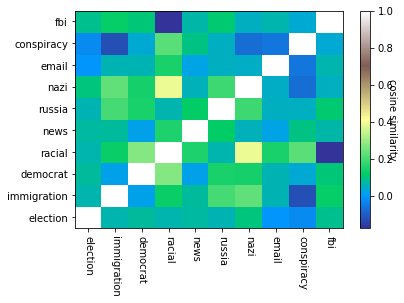

In [47]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = trump_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, trump_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Largest similarity is between `racial` and `nazi`, which is to be expected. Low similarity otherwise. `racial` has a relatively high similarity with `immigration`  and `conspiracy` too, which tells you how much the discourse was driven by racial anxiety.

In [74]:
targetDocs = list(reddit_submissions_trump.sort_values(by = 'score', ascending = False).index[:10])

for (i, idx) in enumerate(targetDocs):
    print("Post", i, ":",
          "userid:", reddit_submissions_trump.loc[idx,'author'],
          "| created_datetime:", reddit_submissions_trump.loc[idx,'created_datetime'],
          "| num_comments:", reddit_submissions_trump.loc[idx,'num_comments'],
          "| score:", reddit_submissions_trump.loc[idx,'score'])
    print(".............")
    print(reddit_submissions_trump.loc[idx,'post_text'])
    print("\n------------- \n")    

Post 0 : userid: OhSnapYouGotServed | created_datetime: 2016-11-09 07:42:06 | num_comments: 12239 | score: 62744
.............
DONALD J. TRUMP DECLARED THE WINNER! #Meme Magic is REAL.

#Donald J. Trump is the next President of the United States of America.

#Let the tendies hit the floor. 

####Donald Trump just proved the entire world wrong. Against insurmountable odds, corruption in the media, sabotage from his own party, and the crush of the establishment machine, DONALD J. TRUMP WON.

####How does it feel, centipedes? The God Emperor said that we would get tired of winning. *ARE YOU TIRED OF WINNING YET?*

#Feel vindicated, centipedes. It's over and there is nothing they can do about it. We are the FUTURE. 

####This is history. YOU are part of history. The_Donald is part of history.

####We did it. We knew this in our hearts. No one believed us. But we *always* knew the truth: THERE ARE NO BRAKES ON THIS TRAIN.

#TRUMP WINS!

------------- 

Post 1 : userid: HIGH_ENERGY_MEMES | c

Interesting collection of posts, ranging for ban-lists, to victory dances, and concerns about censorship.

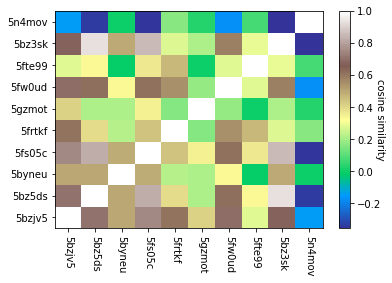

In [68]:
heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = trump_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, 
                                                                 trump_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Here's where we quantify similarity across posts: 1 & 8, 1 & 6, 6 & 8 stand out the most.

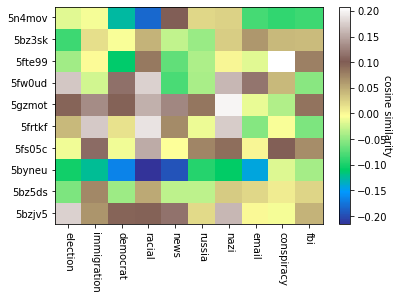

In [69]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = trump_D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, 
                                                                 trump_D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [87]:
heatmapMatrixC[(1,6,8),] > 0.05

array([[False,  True, False,  True, False, False, False, False, False,
        False],
       [ True, False,  True,  True, False, False,  True,  True, False,
        False],
       [False, False, False, False, False, False, False,  True, False,
        False]])

So these posts are loading heavily on `election`, `immigration`, `racial`, `nazi`, `email`.

## Exercise 3 -- Projection

In [ ]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 
                   'black','blacks','African', 'white', 'whites', 'Caucasian', 
                   'Hispanic', 'latino', 'Chinese', 
                   'rich', 'richer', 'richest', 'expensive', 'wealthy', 
                   'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += [
                    'immigration', 'economy']


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(trump_D2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [ ]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [121]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

def makeDF(model, word_list):
    g = []
    i = []
    r_bw = []
    r_hw = []
    r_aw = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(trump_D2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        i.append(sklearn.metrics.pairwise.cosine_similarity(trump_D2V[word].reshape(1,-1), Ideology.reshape(1,-1))[0][0])
        r_bw.append(sklearn.metrics.pairwise.cosine_similarity(trump_D2V[word].reshape(1,-1), Race_bw.reshape(1,-1))[0][0])
        r_hw.append(sklearn.metrics.pairwise.cosine_similarity(trump_D2V[word].reshape(1,-1), Race_hw.reshape(1,-1))[0][0])
        r_aw.append(sklearn.metrics.pairwise.cosine_similarity(trump_D2V[word].reshape(1,-1), Race_aw.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(trump_D2V[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 
                           'ideology': i, 
                           'race_bw': r_bw, 
                           'race_hw': r_hw, 
                           'race_aw': r_aw, 
                           'class': c}, index = word_list)
    return df

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Gender = dimension(trump_D2V, ['man'], ['woman'])
Ideology = dimension(trump_D2V, ['conservative', 'republican', 'right'], ['democrat', 'left', 'liberal'])
Race_bw = dimension(trump_D2V, ['black','african'], ['white', 'caucasian'])
Race_hw = dimension(trump_D2V, ['brown','latino','hispanic', 'mexican'], ['white', 'caucasian'])
Race_aw = dimension(trump_D2V, ['asian','chinese'], ['white', 'caucasian'])
Class = dimension(trump_D2V, ['rich', 'expensive', 'wealthy'], ['poor', 'cheap', 'inexpensive'])

religions = ['christian', 'christianity', 'islam', 'muslim','jewish', 'jew', 'judaism', 'buddhist', 'hindu', 'atheist']
countries = ['europe', 'america', 'mexico', 'libya', 'israel', 'sweden', 'syria', 'iran', 'iraq','afghanistan', 'england']
issues = ['immigration', 'jobs', 'economy', 'security', 'terrorism', 'trade']

religions_df = makeDF(trump_D2V, religions) 
countries_df = makeDF(trump_D2V, countries)
issues_df = makeDF(trump_D2V, issues)

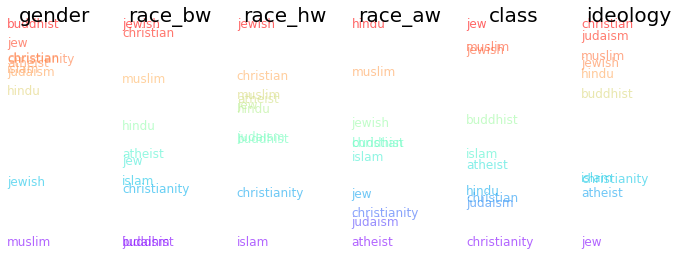

In [123]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(161)
PlotDimension(ax1, religions_df, 'gender')
ax2 = fig.add_subplot(162)
PlotDimension(ax2, religions_df, 'race_bw')
ax3 = fig.add_subplot(163)
PlotDimension(ax3, religions_df, 'race_hw')
ax4 = fig.add_subplot(164)
PlotDimension(ax4, religions_df, 'race_aw')
ax5 = fig.add_subplot(165)
PlotDimension(ax5, religions_df, 'class')
ax6 = fig.add_subplot(166)
PlotDimension(ax6, religions_df, 'ideology')
plt.show()

- Most religions load heavier on `man`
- `buddhist` and `jewish` load heavier on white over black
- `hindu` and `muslim` load heavier on asian over white
- `jew` and `jewish` load heavier on wealth
- Except `jew`, almost all other religions load on the conservative side of the ideology axis

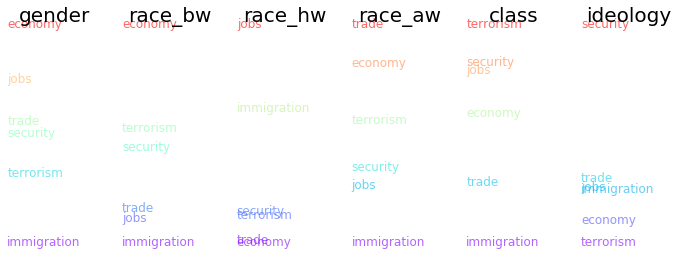

In [125]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(161)
PlotDimension(ax1, issues_df, 'gender')
ax2 = fig.add_subplot(162)
PlotDimension(ax2, issues_df, 'race_bw')
ax3 = fig.add_subplot(163)
PlotDimension(ax3, issues_df, 'race_hw')
ax4 = fig.add_subplot(164)
PlotDimension(ax4, issues_df, 'race_aw')
ax5 = fig.add_subplot(165)
PlotDimension(ax5, issues_df, 'class')
ax6 = fig.add_subplot(166)
PlotDimension(ax6, issues_df, 'ideology')
plt.show()

- `economy` is male, while `immigration` is female?
- `economy` loads much more heavily on black, while `immigration`, `trade`, `jobs` seem to be a more white concern? 
- `jobs` and `immigration` are ditinctly hispanic, while all other issues load more heavily on white
- `immigration` loads more heavily on the poor axis of class, while everything else is closer to the rich class.  
- `security` is distinctly and overwhelmingly a conservative issue

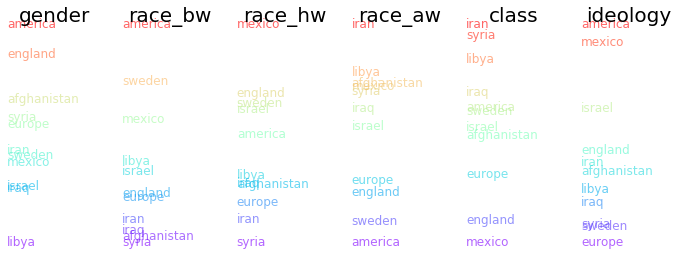

In [127]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(161)
PlotDimension(ax1, countries_df, 'gender')
ax2 = fig.add_subplot(162)
PlotDimension(ax2, countries_df, 'race_bw')
ax3 = fig.add_subplot(163)
PlotDimension(ax3, countries_df, 'race_hw')
ax4 = fig.add_subplot(164)
PlotDimension(ax4, countries_df, 'race_aw')
ax5 = fig.add_subplot(165)
PlotDimension(ax5, countries_df, 'class')
ax6 = fig.add_subplot(166)
PlotDimension(ax6, countries_df, 'ideology')
plt.show()

## Exercise 4a - Scores [Ignore]

In [130]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

In [133]:
donald8_W2Vsoft = gensim.models.word2vec.Word2Vec(reddit_submissions_min8['normalized_sents'].sum(), hs = 1, negative = 0)
donald4_W2Vsoft = gensim.models.word2vec.Word2Vec(reddit_submissions_min4['normalized_sents'].sum(), hs = 1, negative = 0)

In [137]:
reddit_submissions_incels['likelihood_d8'] = reddit_submissions_incels['normalized_sents'].apply(lambda x: adprob(x, donald8_W2Vsoft))
reddit_submissions_incels['likelihood_d4'] = reddit_submissions_incels['normalized_sents'].apply(lambda x: adprob(x, donald4_W2Vsoft))

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [140]:
for post in reddit_submissions_incels.sort_values(by = 'likelihood_d8', ascending = False)['post_text'][:10]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

Who are your favourite and least favourite incels my favourite: alia harkonnen

least favourite: gambler



---------------



#MeTooTeehee xD xD xD


---------------



REE REE REE REE REE! REEEEEEE


---------------



How virgin are you? I am a

1. Kissless
2. Hugless
3. Handholdless
4. Touchless
5. Dateless
6. Complimentless
7. Smileless
8. Phonecallless
9. Textless
10. Friendless

virgin.

EDIT: Added 5, 6, 7


---------------



If you have no jaw and or chin IT'S OVER It's FUCKING OVER FOR ME. I have a subhuman jaw and chin.


---------------



Men How Many Of These Attractive Traits Do You Have https://www.youtube.com/watch?v=EFnJMPQow7A
17:58-22:15




---------------



Chad. Are Chads exclusively white? Do they have to be muscular or...? What are their traits? 


---------------



What kind of -cel are you? I'm:

* Gymcel
* Suicel
* Acnecel
* Narcissist-cel


---------------



˙ʇı ןןɐɔ noʎ ɹǝʌǝʇɐɥʍ ɹo ,ɐʇǝq, pǝɹǝpısuoɔ buıǝq ɟo ʞɔıs ɯ,ı ˙ʇı ʇnoqɐ ʎɹɔ oʇ ǝɯ oʇ ʞןɐʇ ʎןuo pu

In [141]:
for post in reddit_submissions_incels.sort_values(by = 'likelihood_d4', ascending = False)['post_text'][:10]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

#MeTooTeehee xD xD xD


---------------



REE REE REE REE REE! REEEEEEE


---------------



How virgin are you? I am a

1. Kissless
2. Hugless
3. Handholdless
4. Touchless
5. Dateless
6. Complimentless
7. Smileless
8. Phonecallless
9. Textless
10. Friendless

virgin.

EDIT: Added 5, 6, 7


---------------



If you have no jaw and or chin IT'S OVER It's FUCKING OVER FOR ME. I have a subhuman jaw and chin.


---------------



What kind of -cel are you? I'm:

* Gymcel
* Suicel
* Acnecel
* Narcissist-cel


---------------



Fill in the blank It's all about the ___________ .


---------------



˙ʇı ןןɐɔ noʎ ɹǝʌǝʇɐɥʍ ɹo ,ɐʇǝq, pǝɹǝpısuoɔ buıǝq ɟo ʞɔıs ɯ,ı ˙ʇı ʇnoqɐ ʎɹɔ oʇ ǝɯ oʇ ʞןɐʇ ʎןuo puɐ ‘ʇıɥs ǝʞıן ɯǝɥʇ ʇɐǝɹʇ oɥʍ sʎnb bɐqǝɥɔnop ɹǝʇɟɐ ob sʎɐʍןɐ sןɹıb ǝsǝɥʇ puǝ ǝɥʇ uı ˙ʎpɐן,ɯ ɹoɟ buıɥʇʎuɐ op pןnoʍ puɐ ‘qoظ ǝɔıu ɐ ʞɹoʍ ‘ʎnb ǝɔıu ɐ ɯ,ı ˙ǝuoz puǝıɹɟ ǝɥʇ uı ʇnd buıǝq sʎɐʍןɐ ı ɯɐ ʎɥʍ only truecels can read this


---------------



I Have an STD and I'm a Virgin Genital wart. A virgin wit

In [144]:
reddit_submissions_altright['likelihood_d8'] = reddit_submissions_altright['normalized_sents'].apply(lambda x: adprob(x, donald8_W2Vsoft))
reddit_submissions_altright['likelihood_d4'] = reddit_submissions_altright['normalized_sents'].apply(lambda x: adprob(x, donald4_W2Vsoft))

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [145]:
for post in reddit_submissions_altright.sort_values(by = 'likelihood_d8', ascending = False)['post_text'][:10]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

Why is the Irish IQ so low? https://iq-research.info/en/page/average-iq-by-country/ie-ireland

90-92.

Are the Irish an impediment on us Anglos and Germanics?


---------------



Why even call yourselves alt-right? [removed]


---------------



Is anyone here a former SJW but now Alt-Right? Is anyone here a former SJW but now Alt-Right?  If so, how'd that occur?


---------------



What is so great about Homogenization? [removed]


---------------



Can we make a list of pundits, celebrities, etc. who changed their name to hide the fact that they are Jewish? Comments down below with be added:

(((Larry King))) - Lawrence Zeiger

(((Ayn Rand))) - Alisa Rosenbaum

(((Sumner Redstone))) - Sumner Rothstein

(((Woody Allen))) - Allen Konigsberg

(((Mel Brooks))) - Melvin Kaminsky

(((Bob Dylan))) - Robert Zimmerman

(((Rodney Dangerfield))) - Jacob Cohen

(((Jerry Lewis))) - Joseph Levitch

(((Joan Rlvers))) - Joan Molinsky

(((Jon Stewart))) - Jonathan Leibowitz


---------------



Wh

In [146]:
for post in reddit_submissions_altright.sort_values(by = 'likelihood_d4', ascending = False)['post_text'][:10]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

What does everyone think about Anders Breivik? [](https://i.guim.co.uk/img/static/sys-images/Guardian/Pix/pictures/2012/8/24/1345800207399/Anders-Behring-Breivik-sm-010.jpg?w=700&amp;q=55&amp;auto=format&amp;usm=12&amp;fit=max&amp;s=dc508ea668111d96a5826e57a0deec99)


---------------



Can we make a list of pundits, celebrities, etc. who changed their name to hide the fact that they are Jewish? Comments down below with be added:

(((Larry King))) - Lawrence Zeiger

(((Ayn Rand))) - Alisa Rosenbaum

(((Sumner Redstone))) - Sumner Rothstein

(((Woody Allen))) - Allen Konigsberg

(((Mel Brooks))) - Melvin Kaminsky

(((Bob Dylan))) - Robert Zimmerman

(((Rodney Dangerfield))) - Jacob Cohen

(((Jerry Lewis))) - Joseph Levitch

(((Joan Rlvers))) - Joan Molinsky

(((Jon Stewart))) - Jonathan Leibowitz


---------------



What is so great about Homogenization? [removed]


---------------



Is anyone here a former SJW but now Alt-Right? Is anyone here a former SJW but now Alt-Right?  If so, 

In [147]:
reddit_submissions_altright.head()

,author,created_utc,subreddit,title,selftext,distinguished,created_datetime,created_tranche,post_text,tokenized_sents,normalized_sents,likelihood_d8,likelihood_d4
id,,,,,,,,,,,,,
4dgf5j,avian_buddha,1459863156,altright,List of Alt Right Websites,Let's get a list going so that anybody can com...,moderator,2016-04-05 13:32:36,4,List of Alt Right Websites Let's get a list go...,"[[List, of, Alt], [Right, Websites, Let, 's, g...","[[list, alt], [right, website, let, list, go, ...",-10.893825,-11.331831
4rj06j,AugustJRush,1467818739,altright,What type of content do you guys like to see?,"Would you folk like to see more news stories, ...",NaN,2016-07-06 15:25:39,6,What type of content do you guys like to see? ...,"[[What, type, of, content, do, you, guys, like...","[[type, content, guy, like], [folk, like, news...",-40.145859,-42.458706
4s2m7h,LetThereBeWhite,1468103206,altright,"Damn, 250 subscribers to 450 in less than a we...",_____________\n\n-\n\n# For once in its cuck l...,moderator,2016-07-09 22:26:46,6,"Damn, 250 subscribers to 450 in less than a we...","[[Damn, 250, subscribers, to, 450, in, less, t...","[[damn, subscriber, week], [time], [time, red,...",-24.340067,-24.601299
4s39s6,AugustJRush,1468113131,altright,How do you describe your political leanings to...,"I usually just go with ""Far-Right"", which is g...",NaN,2016-07-10 01:12:11,6,How do you describe your political leanings to...,"[[How, do, you, describe, your, political, lea...","[[describe, political, leaning, normies], [usu...",-19.518883,-17.469717
4s63m0,YukonAurelius,1468167550,altright,Any interest in alt-right reading group?,"I was thinking of digging into Spengler's ""Dec...",NaN,2016-07-10 16:19:10,6,Any interest in alt-right reading group? I was...,"[[Any, interest, in, alt, right, reading, grou...","[[interest, alt, right, read, group], [think, ...",-41.660336,-43.229820


In [150]:
reddit_submissions_con['likelihood_d8'] = reddit_submissions_con['normalized_sents'].apply(lambda x: adprob(x, donald8_W2Vsoft))
reddit_submissions_con['likelihood_d4'] = reddit_submissions_con['normalized_sents'].apply(lambda x: adprob(x, donald4_W2Vsoft))

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [151]:
reddit_submissions_con.head()

,author,created_utc,subreddit,title,selftext,distinguished,created_datetime,created_tranche,post_text,tokenized_sents,normalized_sents,likelihood_d8,likelihood_d4
id,,,,,,,,,,,,,
39tbk2,nicksvr4,1434297481,Conservative,"TIL the US has greater purchasing power, and m...",[Greater purchasing power](https://en.wikipedi...,NaN,2015-06-14 15:58:01,0,"TIL the US has greater purchasing power, and m...","[[TIL, the, US, has, greater, purchasing, powe...","[[til, great, purchase, power, median, income,...",-38.261856,-36.791939
3ajpuq,CherryCokeNixon,1434836077,Conservative,Social Justice Question,So I came to the (obvious) realization that mo...,NaN,2015-06-20 21:34:37,0,Social Justice Question So I came to the (obvi...,"[[Social, Justice, Question], [So, I, came, to...","[[social, justice, question], [come, obvious, ...",-68.008835,-60.837463
3avdye,PetitGarou,1435091303,Conservative,You've got to love all of the morons obsessing...,Manipulative Media + the useful idiots on the ...,NaN,2015-06-23 20:28:23,0,You've got to love all of the morons obsessing...,"[[You, 've, got, to, love, all, of, the, moron...","[[have, get, love, moron, obsess, flag, respon...",-35.860771,-29.583855
3b31nn,Mispelling,1435247307,Conservative,What is your prediction for the votes in the s...,Do you think it will be 5-4? 6-3? 9-0?,NaN,2015-06-25 15:48:27,0,What is your prediction for the votes in the s...,"[[What, is, your, prediction, for, the, votes,...","[[prediction, vote, sex, marriage, scotus, cas...",-21.279634,-20.450972
3b89ek,Yosoff,1435347577,Conservative,"""Today's decision shows that decades of attemp...",This thread is ONLY for Social and/or Constitu...,moderator,2015-06-26 19:39:37,0,"""Today's decision shows that decades of attemp...","[[Today, 's, decision, shows, that, decades, o...","[[today, decision, show, decade, attempt, rest...",-22.359842,-22.088705


In [152]:
for post in reddit_submissions_con.sort_values(by = 'likelihood_d4', ascending = False)['post_text'][:5]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

Pre-Debate Thread - Republican Debate on CNN - 8:30pm EST **[Ted Cruz](https://tedcruz.org)** ............. **/r/TedCruzForPresident**

**[John Kasich](https://johnkasich.com)** ........ **/r/KasichForPresident**

**[Marco Rubio](https://marcorubio.com)** ....... **/r/Marco_Rubio**

**[Donald Trump](https://www.donaldjtrump.com/)** .... **/r/The_Donald**

----

http://www.cnn.com/2016/03/10/politics/republican-debate/index.html


---------------



Post-Debate Discussion Thread **Prime-time Debate Candidates (9pm Eastern Time):**  
  
* **[Jeb Bush](https://jeb2016.com)**
  
* **[Ben Carson](https://www.bencarson.com)**
  
* **[Chris Christie](https://www.chrischristie.com)**
  
* **[Ted Cruz](https://tedcruz.org)**
  
* **[John Kasich](https://johnkasich.com)**
  
* **[Marco Rubio](https://marcorubio.com)**
  
* **[Donald Trump](https://www.donaldjtrump.com/)**



---------------



Fox News Republican Main Debate Open Thread ***If you haven't registered to vote, [you may do so here.]

In [153]:
for post in reddit_submissions_con.sort_values(by = 'likelihood_d8', ascending = False)['post_text'][:5]:
    print (post + '\n\n\n' + '---------------' +'\n\n\n')

Pre-Debate Thread - Republican Debate on CNN - 8:30pm EST **[Ted Cruz](https://tedcruz.org)** ............. **/r/TedCruzForPresident**

**[John Kasich](https://johnkasich.com)** ........ **/r/KasichForPresident**

**[Marco Rubio](https://marcorubio.com)** ....... **/r/Marco_Rubio**

**[Donald Trump](https://www.donaldjtrump.com/)** .... **/r/The_Donald**

----

http://www.cnn.com/2016/03/10/politics/republican-debate/index.html


---------------



Post-Debate Thread - Fox Business Network &amp; Wall Street Journal Republican Party Debate **Early Debate Candidates:**  
  
* **[Chris Christie](https://www.chrischristie.com)**
  
* **[Mike Huckabee](https://mikehuckabee.com)**
  
* **[Bobby Jindal](https://www.bobbyjindal.com)**
  
* **[Rick Santorum](https://ricksantorum.com)**
  
**[Jim Gilmore](http://www.gilmoreforamerica.com/),** **[Lindsey Graham](http://www.lindseygraham.com/),** and **[George Pataki](http://www.georgepataki.com)** did not qualify for the debate.   
  
----  
  
*

## Exercise 4b -- Linguistic Change

In [144]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

def compareModels(df, category, sg_param, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum(), sg = sg_param)
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

In [11]:
reddit_submissions_trump2 = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'The_Donald')]
reddit_submissions_trump2['post_text'] = reddit_submissions_trump2['title'] + " " + reddit_submissions_trump2['selftext']
reddit_submissions_trump2['tokenized_sents'] = reddit_submissions_trump2['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_trump2['normalized_sents'] = reddit_submissions_trump2['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [146]:
reddit_submissions_trump2 = reddit_submissions_trump[reddit_submissions_trump['created_utc'].isin(range(1454284800,1522540800))]
reddit_submissions_trump2['created_myear'] = pandas.to_datetime(reddit_submissions_trump2['created_datetime']).dt.to_period('M')

/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [147]:
rawEmbeddings2, comparedEmbeddings2 = compareModels(reddit_submissions_trump2, 'created_myear', sg_param=1)

military


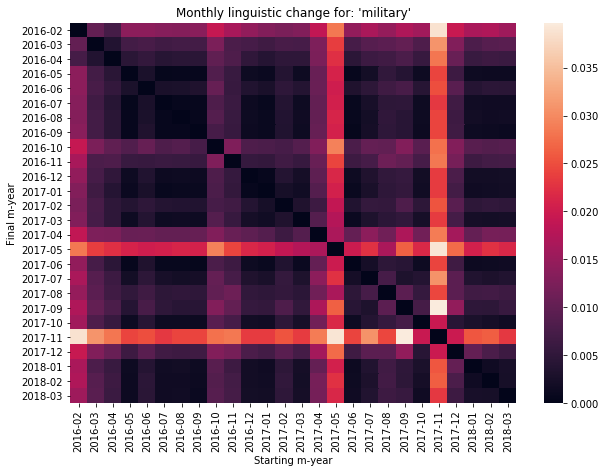

In [148]:
targetWord = 'military' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

email


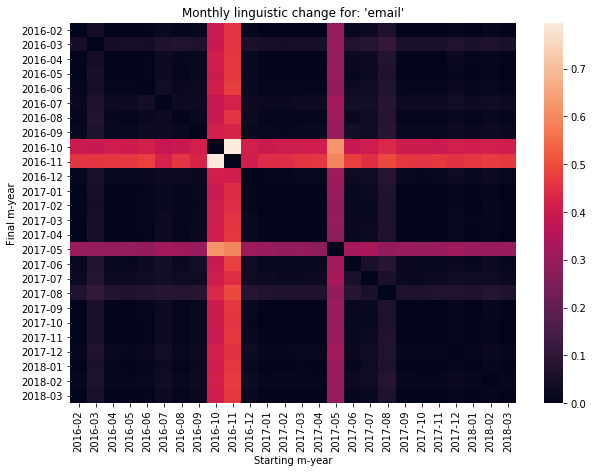

In [149]:
targetWord = 'email' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

Ha. Emails only mattered in the election window, and then when the Muller investigation kicked up a notch.

white


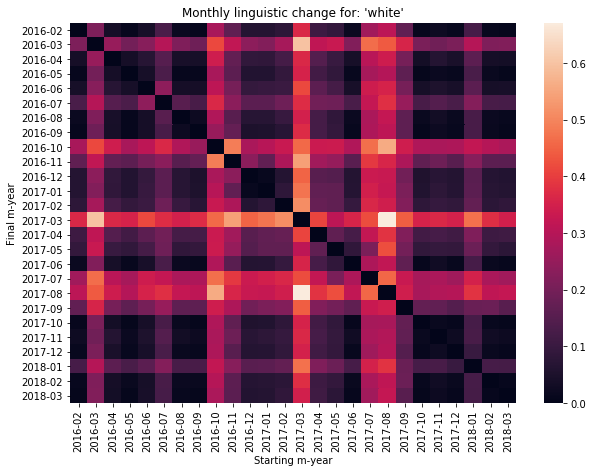

In [150]:
targetWord = 'white' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

The big flare-up in 2017-March: Charlottesville. We can see the knock-on effects in the subsequent months.

hack


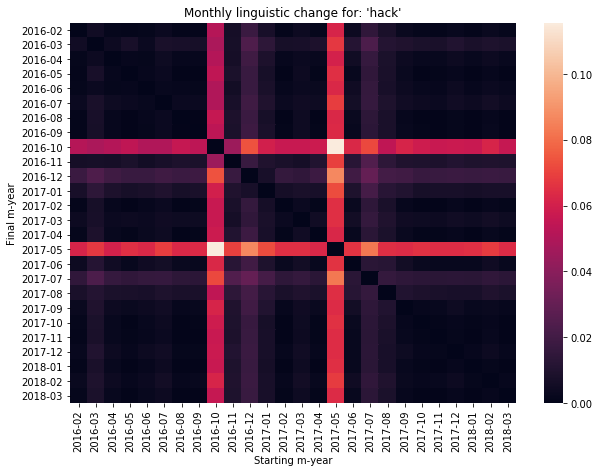

In [151]:
targetWord = 'hack' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

Again, Mueller investigation and the election month. Tells you so much about the attention span for issues.

russia


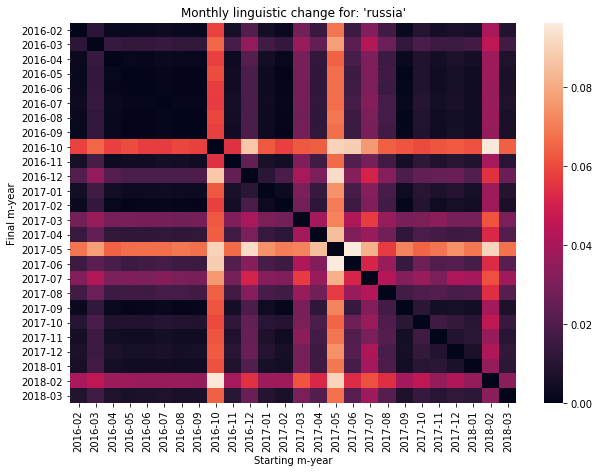

In [152]:
targetWord = 'russia' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

Same pattern of flare-ups as `hack` and `email`

republican


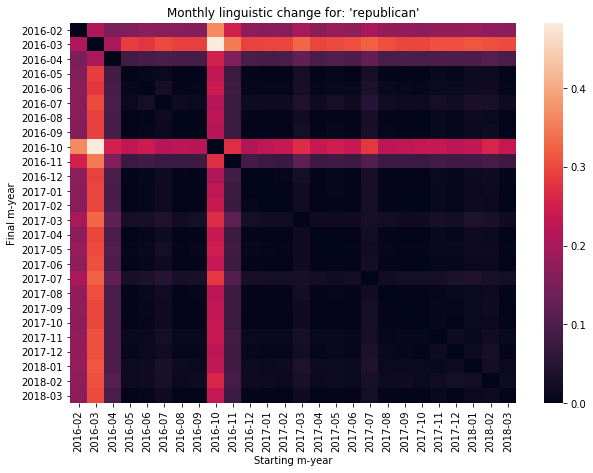

In [154]:
targetWord = 'republican' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

fbi


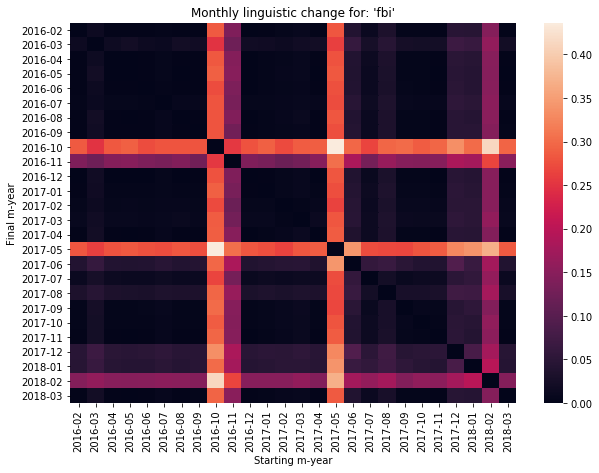

In [155]:
targetWord = 'fbi' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

tweet


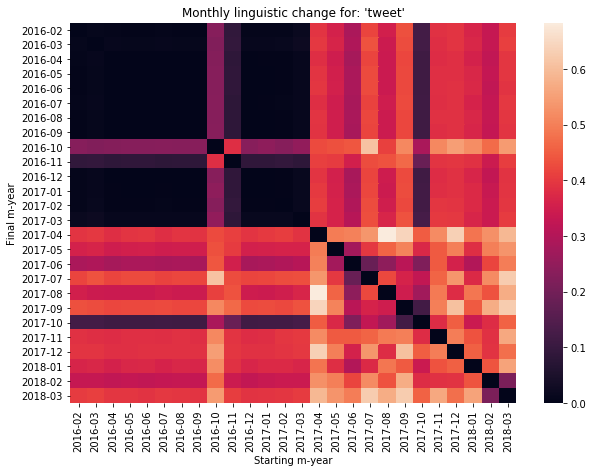

In [156]:
targetWord = 'tweet' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

facebook


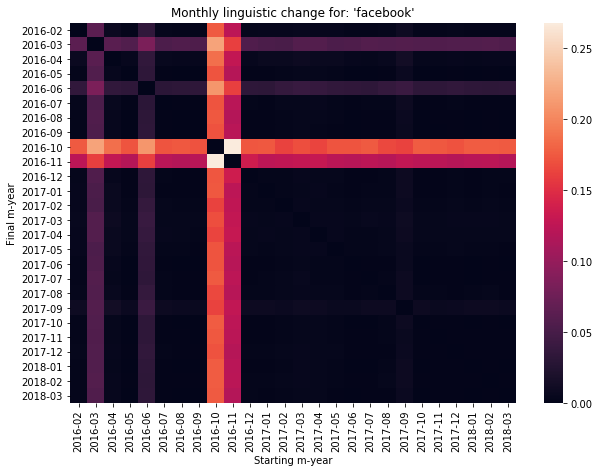

In [157]:
targetWord = 'facebook' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

twitter


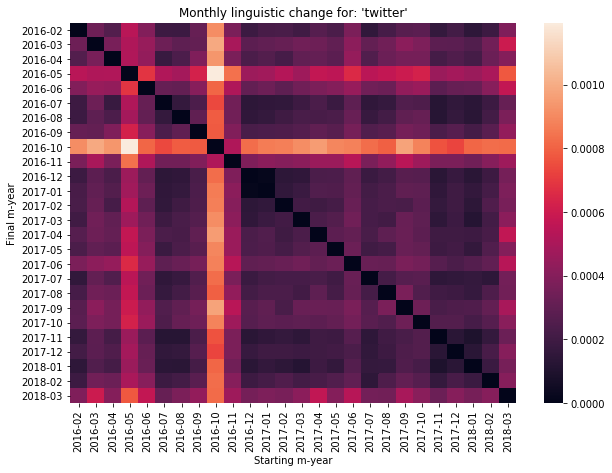

In [117]:
targetWord = 'twitter' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

news


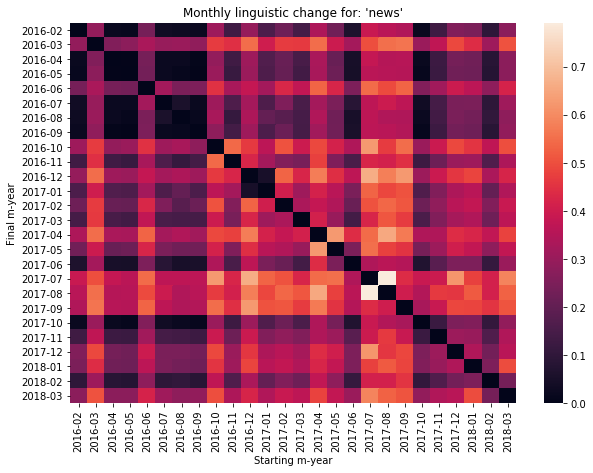

In [158]:
targetWord = 'news' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

The meaning and association of `news` keeps changing quite a bit every month. A possible effect of the attention Trump and his supporters have lavished on making the media the enemy.

russia


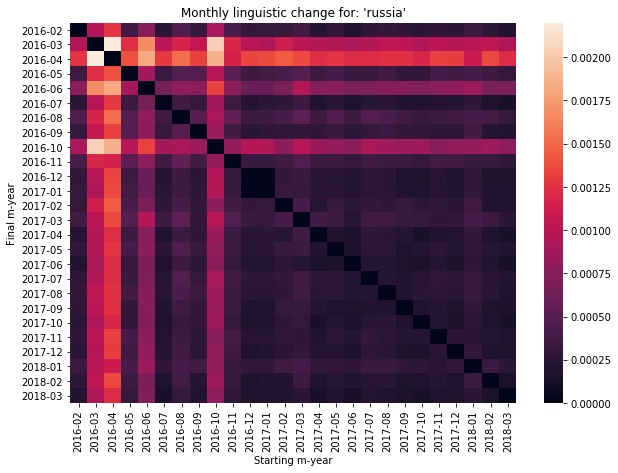

In [15]:
targetWord = 'russia' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

immigrant


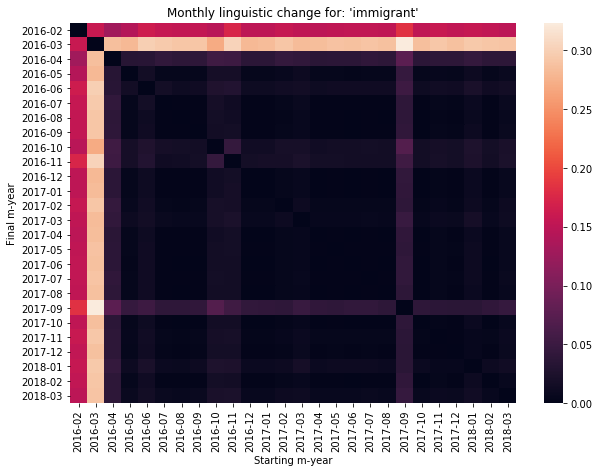

In [159]:
targetWord = 'immigrant' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

immigration


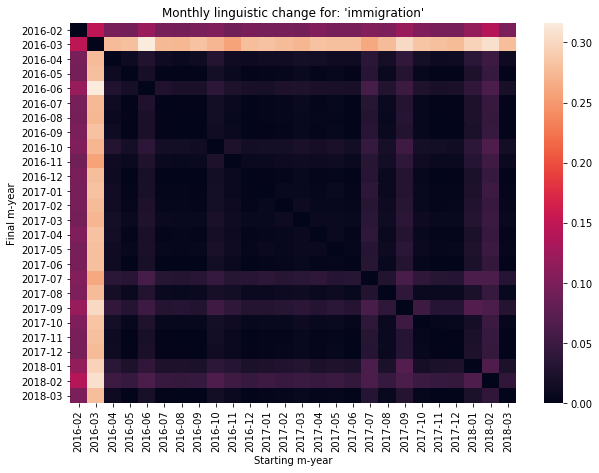

In [160]:
targetWord = 'immigration' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

obama


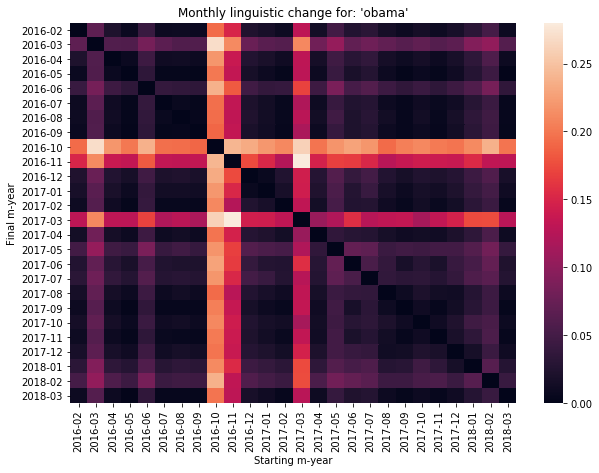

In [161]:
targetWord = 'obama' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

trump


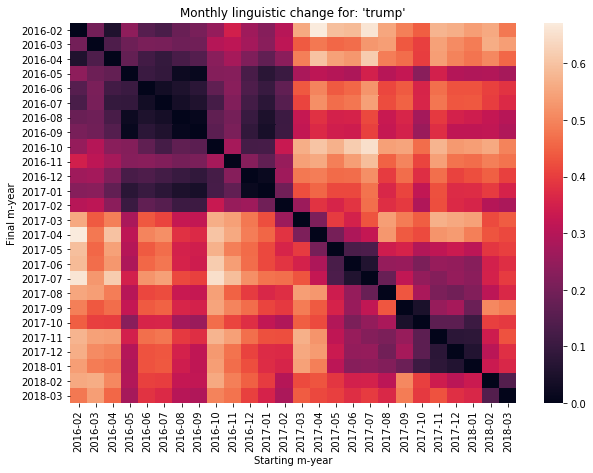

In [162]:
targetWord = 'trump' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

class


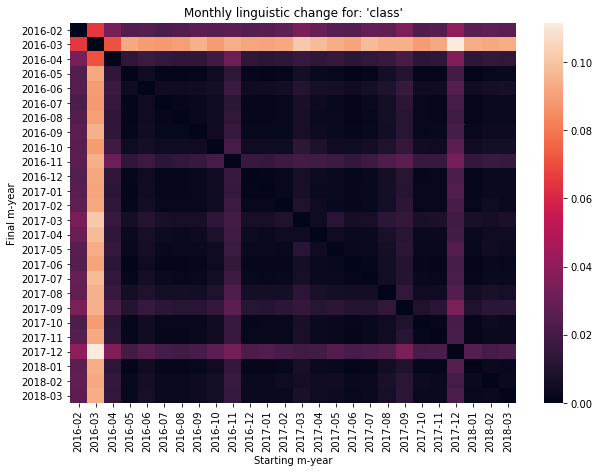

In [169]:
targetWord = 'class' #elite, america, news, 

pltDF = getDivergenceDF(targetWord, comparedEmbeddings2)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting m-year")
ax.set_ylabel("Final m-year")
ax.set_ylabel("Final m-year")
ax.set_title("Monthly linguistic change for: '{}'".format(targetWord))
plt.show()

In [164]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [165]:
wordDivergences2 = findMostDivergent(comparedEmbeddings2)

Found 924 words to compare


In [166]:
wordDivergences2[:25]

[('=', 12.60293097794056),
 ('energy', 12.255465745925903),
 ('high', 10.704167604446411),
 ('the_donald', 10.100698739290237),
 ('trump', 9.844197511672974),
 ('r', 9.471028864383698),
 ('great', 8.62985497713089),
 ('america', 8.474105834960938),
 ('low', 8.36773943901062),
 ('donald', 8.318232417106628),
 ('state', 7.57592099905014),
 ('/r', 6.8591228723526),
 ('president', 6.8542467057704926),
 ('$', 6.745738536119461),
 ('win', 6.575217843055725),
 ('illegal', 6.266872882843018),
 ('post', 6.139272630214691),
 ('new', 5.892671346664429),
 ('vote', 5.486355841159821),
 ('election', 5.185125052928925),
 ('supporter', 5.122274160385132),
 ('hillary', 5.116934955120087),
 ('job', 5.056299924850464),
 ('sub', 4.870733201503754),
 ('press', 4.850227773189545)]

In [111]:
wordDivergences2[-10:]

[('hold', 0.004893362522125244),
 ('force', 0.004736363887786865),
 ('use', 0.004646182060241699),
 ('little', 0.00458604097366333),
 ('public', 0.004486501216888428),
 ('end', 0.004378080368041992),
 ('order', 0.004345953464508057),
 ('turn', 0.004045367240905762),
 ('allow', 0.003776073455810547),
 ('base', 0.0030490756034851074)]